In [1]:
import numpy as np
import os
import cv2 as cv
from sklearn.model_selection import train_test_split
import tensorflow as tf
real_data = "SOCOFing/Real"
altered_data = "SOCOFing/Altered"

Sokoto Coventry Fingerprint Dataset (SOCOFing) is a biometric fingerprint database designed for academic research purposes. SOCOFing is made up of 6,000 fingerprint images from 600 African subjects and contains unique attributes such as labels for gender, hand and finger name as well as synthetically altered versions with three different levels of alteration for obliteration, central rotation, and z-cut. For a complete formal description and usage policy please refer to the following paper: https://arxiv.org/abs/1807.10609

In [2]:
data = []
labels = []

# load the real data and their labels
photos_names = os.listdir(real_data)
for name in photos_names:
    data.append(cv.imread(os.path.join(real_data ,name) ,cv.IMREAD_GRAYSCALE))
    labels.append(0)

# load the altered data and their labels
dirs = ["Altered-Easy" ,"Altered-Hard" ,"Altered-Medium"]
for folder in dirs:
    photos_names = os.listdir(os.path.join(altered_data ,folder))
    for name in photos_names:
        data.append(cv.imread(os.path.join(altered_data ,folder ,name) ,cv.IMREAD_GRAYSCALE))
        labels.append(1)

In [3]:
x = 96
y = 103

In [4]:
# resizeing all the data to 103X96
for i,image in enumerate(data):
    data[i] = cv.resize(image ,(x,y))
    
data = np.stack(data).reshape(-1 ,y ,x ,1)
labels = np.stack(labels).reshape(-1 ,1)

In [5]:
train_data, test_data, train_labels, test_labels  = train_test_split(data, labels, test_size=0.2, random_state=42)

In [6]:
# print the shape of the data for each image
i = 0
for image in train_data:
    if image.shape != (y, x, 1):
        i += 1
print('images without the correct shape: ', i)

images without the correct shape:  0


[1]


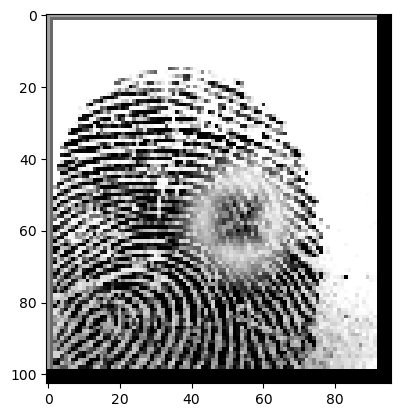

In [7]:
# visualization of 1 image from train data
import matplotlib.pyplot as plt
print(train_labels[0])
plt.imshow(train_data[0], cmap='gray')
plt.show()

In [6]:
# converting numpy arrays to tensors
train_data_tensor = tf.convert_to_tensor(train_data, dtype=tf.float16)
test_data_tensor = tf.convert_to_tensor(test_data, dtype=tf.float16)
train_labels_tensor = tf.convert_to_tensor(train_labels, dtype=tf.int16)
test_labels_tensor = tf.convert_to_tensor(test_labels, dtype=tf.int16)

# converting to 3 channels
train_data_3 = tf.image.grayscale_to_rgb(train_data_tensor)
test_data_3 = tf.image.grayscale_to_rgb(test_data_tensor)

### Using Cross Entropy loss

In [9]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Flatten, Dense
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(y, x, 3))
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  
predictions = Dense(1, activation='sigmoid')(x)  

# Creating model combining the base of ResNet50 and the new custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Visualizing the network architecture
# model.summary()

model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])
model.fit(train_data_3, train_labels_tensor, epochs=10, batch_size=32, validation_split=0.2)

y_pred = model.predict(test_data_3)


print("Balanced Accuracy: " +  str(balanced_accuracy_score(test_labels_tensor, np.rint(y_pred))))
print("Confusion Matrix: " +  str(confusion_matrix(test_labels_tensor, np.rint(y_pred))))

Epoch 1/10
1106/1106 [==============================] - 47s 38ms/step - loss: 0.3842 - accuracy: 0.8997 - val_loss: 0.2100 - val_accuracy: 0.8999
Epoch 2/10
1106/1106 [==============================] - 42s 38ms/step - loss: 0.1766 - accuracy: 0.9182 - val_loss: 0.1968 - val_accuracy: 0.9074
Epoch 3/10
1106/1106 [==============================] - 43s 39ms/step - loss: 0.1666 - accuracy: 0.9233 - val_loss: 0.1853 - val_accuracy: 0.9149
Epoch 4/10
1106/1106 [==============================] - 43s 39ms/step - loss: 0.1571 - accuracy: 0.9282 - val_loss: 0.1826 - val_accuracy: 0.9153
Epoch 5/10
1106/1106 [==============================] - 42s 38ms/step - loss: 0.1473 - accuracy: 0.9318 - val_loss: 0.1816 - val_accuracy: 0.9117
Epoch 6/10
1106/1106 [==============================] - 42s 38ms/step - loss: 0.1411 - accuracy: 0.9366 - val_loss: 0.1818 - val_accuracy: 0.9170
Epoch 7/10
1106/1106 [==============================] - 41s 37ms/step - loss: 0.1329 - accuracy: 0.9392 - val_loss: 0.1773 -

### Using Binary Accuracy metric

In [9]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Flatten, Dense
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(y, x, 3))
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  
predictions = Dense(1, activation='sigmoid')(x)  

# Creating model combining the base of ResNet50 and the new custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Visualizing the network architecture
# model.summary()

tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)

model.compile(optimizer='adam', loss="binary_crossentropy", metrics=[tf.keras.metrics.BinaryAccuracy()])
model.fit(train_data_3, train_labels_tensor, epochs=10, batch_size=32, validation_split=0.2)

y_pred = model.predict(test_data_3)


print("Balanced Accuracy: " +  str(balanced_accuracy_score(test_labels_tensor, np.rint(y_pred))))
print("Confusion Matrix: " +  str(confusion_matrix(test_labels_tensor, np.rint(y_pred))))

Epoch 1/10
1106/1106 [==============================] - 47s 38ms/step - loss: 0.4522 - binary_accuracy: 0.8996 - val_loss: 0.1870 - val_binary_accuracy: 0.9121
Epoch 2/10
1106/1106 [==============================] - 40s 37ms/step - loss: 0.1767 - binary_accuracy: 0.9186 - val_loss: 0.1873 - val_binary_accuracy: 0.9137
Epoch 3/10
1106/1106 [==============================] - 40s 37ms/step - loss: 0.1681 - binary_accuracy: 0.9231 - val_loss: 0.2045 - val_binary_accuracy: 0.9107
Epoch 4/10
1106/1106 [==============================] - 41s 37ms/step - loss: 0.1605 - binary_accuracy: 0.9253 - val_loss: 0.1754 - val_binary_accuracy: 0.9142
Epoch 5/10
1106/1106 [==============================] - 41s 37ms/step - loss: 0.1563 - binary_accuracy: 0.9297 - val_loss: 0.1790 - val_binary_accuracy: 0.9159
Epoch 6/10
1106/1106 [==============================] - 40s 37ms/step - loss: 0.1427 - binary_accuracy: 0.9349 - val_loss: 0.1874 - val_binary_accuracy: 0.9134
Epoch 7/10
1106/1106 [==================

### Using Image Random Flip

In [7]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Flatten, Dense, RandomFlip
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(y, x, 3))
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
x = RandomFlip("horizontal")(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  
predictions = Dense(1, activation='sigmoid')(x)  

# Creating model combining the base of ResNet50 and the new custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Visualizing the network architecture
# model.summary()

tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)

model.compile(optimizer='adam', loss="binary_crossentropy", metrics=[tf.keras.metrics.BinaryAccuracy()])
model.fit(train_data_3, train_labels_tensor, epochs=10, batch_size=32, validation_split=0.2)

y_pred = model.predict(test_data_3)


print("Balanced Accuracy: " +  str(balanced_accuracy_score(test_labels_tensor, np.rint(y_pred))))
print("Confusion Matrix: " +  str(confusion_matrix(test_labels_tensor, np.rint(y_pred))))

Epoch 1/10
1106/1106 [==============================] - 60s 49ms/step - loss: 0.4693 - binary_accuracy: 0.9030 - val_loss: 0.2254 - val_binary_accuracy: 0.9023
Epoch 2/10
1106/1106 [==============================] - 55s 49ms/step - loss: 0.1737 - binary_accuracy: 0.9207 - val_loss: 0.2462 - val_binary_accuracy: 0.8814
Epoch 3/10
1106/1106 [==============================] - 55s 49ms/step - loss: 0.1612 - binary_accuracy: 0.9263 - val_loss: 0.2060 - val_binary_accuracy: 0.9064
Epoch 4/10
1106/1106 [==============================] - 54s 49ms/step - loss: 0.1509 - binary_accuracy: 0.9318 - val_loss: 0.2144 - val_binary_accuracy: 0.8981
Epoch 5/10
1106/1106 [==============================] - 54s 48ms/step - loss: 0.1440 - binary_accuracy: 0.9345 - val_loss: 0.2309 - val_binary_accuracy: 0.9017
Epoch 6/10
1106/1106 [==============================] - 53s 48ms/step - loss: 0.1364 - binary_accuracy: 0.9391 - val_loss: 0.2641 - val_binary_accuracy: 0.9028
Epoch 7/10
1106/1106 [==================

### Using Binary Focal loss

In [9]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Flatten, Dense, RandomRotation, RandomFlip, RandomZoom

# passar pra 3 canais
# incluir uma camada que faça a classificacao
# flatten
# densa
# classificacao

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(y, x, 3))
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
# x = RandomFlip("horizontal")(x)
# x = RandomZoom(0.2)(x)
# x = RandomRotation(0.2)(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  
predictions = Dense(1, activation='sigmoid')(x)  

# Creating model combining the base of ResNet50 and the new custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Visualizing the network architecture
# model.summary()

In [10]:
tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)

In [11]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0), metrics=[tf.keras.metrics.BinaryAccuracy()])
model.fit(train_data_3, train_labels_tensor, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
1106/1106 [==============================] - 47s 38ms/step - loss: 0.3548 - binary_accuracy: 0.8941 - val_loss: 0.0571 - val_binary_accuracy: 0.8967
Epoch 2/10
1106/1106 [==============================] - 40s 37ms/step - loss: 0.0434 - binary_accuracy: 0.9251 - val_loss: 0.0515 - val_binary_accuracy: 0.9036
Epoch 3/10
1106/1106 [==============================] - 40s 36ms/step - loss: 0.0430 - binary_accuracy: 0.9241 - val_loss: 0.0500 - val_binary_accuracy: 0.9056
Epoch 4/10
1106/1106 [==============================] - 39s 35ms/step - loss: 0.0425 - binary_accuracy: 0.9251 - val_loss: 0.0468 - val_binary_accuracy: 0.9185
Epoch 5/10
1106/1106 [==============================] - 39s 35ms/step - loss: 0.0442 - binary_accuracy: 0.9216 - val_loss: 0.0490 - val_binary_accuracy: 0.9100
Epoch 6/10
1106/1106 [==============================] - 39s 35ms/step - loss: 0.0410 - binary_accuracy: 0.9269 - val_loss: 0.0490 - val_binary_accuracy: 0.9154
Epoch 7/10
1106/1106 [==================

In [12]:
y_pred = model.predict(test_data_3)

346/346 [==============================] - 9s 23ms/step


In [15]:
a= np.rint(y_pred)

unique, counts = np.unique(a, return_counts=True)

dict(zip(unique, counts))

{0.0: 1556, 1.0: 9498}

In [16]:
# calculate the balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print(balanced_accuracy_score(test_labels_tensor, np.rint(y_pred)))

0.8390284937523222


In [17]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(test_labels_tensor, np.rint(y_pred))
print(conf_mat)

[[ 909  313]
 [ 647 9185]]
